<h1>Pre-work</h1>

On my laptop I can't run the code for the entire dataframe, so it's going to be on the half and we'll have to run it at th library over more powerfull laptop. Unless one of us has a powerful enough laptop. 

In [3]:
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import matplotlib.pyplot as plt

import string

from nltk import sent_tokenize,word_tokenize

from nltk import FreqDist

from wordcloud import WordCloud, STOPWORDS

from datetime import datetime

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

start_time = datetime.now()

<h2>Processing functions</h2>

<h3>Normalization Function</h3>

<h4>Normalization over number of words

In [4]:
def normalization_word(var):
    #returns the # of words
    words = nltk.Text(word_tokenize(((var))))
    return len(words)

<h4>Normalization by number of Sentences</h4>

In [3]:
def normalization_sentence(var):
    #returns the # of sentences
    sentences = nltk.Text(sent_tokenize(var))
    return len(sentences)

<h4>Normalization by number of Characters</h4>


In [4]:
def normalization_character(var):
    #returns the # of characters
    return len(var)

<h3>Cleaning Function</h3>

In [5]:
def cleaning(var): #takes a string, returns a string 
    plain_string = ""
    for x in var:
        x = x.lower()
        if (( 'a' <= x and x <= 'z') or x == ' '):
            plain_string += x
        elif x == '\'': #we replace the ' by a space 
            plain_string += ' '
    return plain_string 

<h3>Creation of the dataframes</h3>

In [6]:
train = pd.read_csv("train.csv")
author_list = ['EAP', 'HPL', 'MWS']
train.text= train.text.astype(str)
train.author = pd.Categorical(train.author)

start_time = datetime.now()

train = train[0:100]  #size reduction for coding

train_back_up = train.copy()     #back up is used to define the future dataframes

In [7]:
#this cell is just for coding and testing the functions

test = train['text'][0]
test2 = train['text'][39] #with "blabla"
test3 = train['text'][70] #with 2 times "blabla"


<h1>Splitting the training set.</h1>
<br>
Because we have only two dataset, one for training and the other for the Kaggle test. We need to split our 'Kaggle training' set (called t0) into training (called tr1) (in the sense of the training of our predictive model) and testing set (called ts1) ( in the sense of testing our models, and not be tested by Kaggle ! ). <br>
<br>
We shall notice we will choose the best classifier only with the TR1 DataSet. Then, we will test this classifier with TS1 to see if we over-fitted over TR1.<br>
<br>

Once we chose the classifier, checked the over-fitting, we will be able to train a the chosen classifier over TR1 and TS1. And so, we'll be able to predict over the "Kaggle Test Dataset" and submit the file. 

In [8]:
t0 = train.copy()

In [9]:
from sklearn.model_selection import train_test_split

split_coef = 20/80 #80% for tr1, 20% for ts1   Maybe we'll have to change

tr1, ts1 = train_test_split(t0, test_size = split_coef)

#we must study further, it's possible to choose parameters... (TBD)

print( len(t0))
print(len(tr1))
print(len(ts1))
print(len(tr1)/len(t0))
print(len(ts1)/len(t0))
print(len(tr1)/len(t0) + len(ts1)/len(t0))

100
75
25
0.75
0.25
1.0


<h1>Feature Engineering</h1>

<h2>Meta-Data</h2>

<h3>Average sentence length (in characters)</h3>

In [10]:
def length_character(var):#takes string, return int
    return len(var)/normalization_sentence(var)

<h3>Average sentence length (in words)</h3>

In [11]:
def length_sentence(var):#takes string, return int
    return len(var.split())/normalization_sentence(var)

<h3>Average characters per word</h3>

In [12]:
def length_word(var):#takes string, return int
    return len(var.split())/normalization_word(var) #only word and not punctuations

<h3>Punctuation density</h3>
Maybe some punctuation of forgot. We should check it.

In [13]:
def density_coma(var):#take a string, a punc, return a ratio
    cpunc = 0
    for x in var:
        if x == ',':
            cpunc +=1
    return cpunc/normalization_character(var)

In [14]:
def density_point(var):#take a string, a punc, return a ratio
    cpunc = 0
    for x in var:
        if x == '.':
            cpunc +=1
    return cpunc/normalization_character(var)

In [15]:
def density_double_point(var):#take a string, a punc, return a ratio
    cpunc = 0
    for x in var:
        if x == ':':
            cpunc +=1
    return cpunc/normalization_character(var)

In [16]:
def density_semi_comma(var):#take a string, a punc, return a ratio
    cpunc = 0
    for x in var:
        if x == ';':
            cpunc +=1
    return cpunc/normalization_character(var)

In [17]:
def density_interro(var):#take a string, a punc, return a ratio
    cpunc = 0
    for x in var:
        if x == '?':
            cpunc +=1
    return cpunc/normalization_character(var)

In [18]:
def density_expl(var):#take a string, a punc, return a ratio
    cpunc = 0
    for x in var:
        if x == '!':
            cpunc +=1
    return cpunc/normalization_character(var)

<h3>Percentage of unique words per sentence</h3>

In [19]:
def vocabulary_sentence(var):#take string, return int
    var = nltk.Text(sent_tokenize(var))
    vocabulary_list = []
    for c in var:
        if normalization_word(c)!= 0:
            vacabulary_count_sentence = len({x.lower() for x in word_tokenize(cleaning(c))})
            vocabulary_list.append(vacabulary_count_sentence/normalization_word(c))
    return np.mean(vocabulary_list)

<h3>Stopword percentage</h3>

In [20]:
def density_stopword(var):#take a string, return an integer
    cs = 0
    for x in nltk.Text(word_tokenize(var)):
        if x in STOPWORDS:
            cs +=1
    return cs/normalization_word(var)

<h3>Noun Density</h3>

In [21]:
def density_noun(var):
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2]=='NN': #all the noun tags start with NN
            l.append(x)
    return len(l)/normalization_word(var)

<h3>Verb Density</h3>

In [22]:
def density_verb(var):
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2]=='VB': #all the noun tags start with NN
            l.append(x)
    return len(l)/normalization_word(var)

<h3>Adjective Density</h3>

In [23]:
def density_adjective(var):
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2]=='JJ': #all the noun tags start with NN
            l.append(x)
    return len(l)/normalization_word(var)

<h3>Adjective to noun ratio</h3>

In [24]:
 def adjective_to_noun(var):
    return (density_adjective(var))/(density_noun(var)+ 0.5) #because of division by 0

<h3>Building of the Dataframe of Metadata</h3>

In [25]:
#could be modified if we add meta_data
list_meta = [length_character,
             length_sentence,
             length_word,  
             vocabulary_sentence,
             density_stopword,
             density_noun,
             density_verb,
             density_adjective,
             adjective_to_noun,
             density_coma,
             density_point,
             density_double_point,
             density_semi_comma,
             density_interro,
             density_expl
            ]

In [26]:
def build_meta(dataframe):
    df_meta = dataframe.copy()
    
    for f in list_meta:
        df_meta[f.__name__] = df_meta.text.apply(f)
        
    return df_meta


#build_meta(tr1)
        

<h2>Counting of words (a.k.a bag of words)</h2>

Some words about tf_idf: https://buhrmann.github.io/tfidf-analysis.html. <br>
Here, we don't detail for each N. I mean we'll run the tf_idf for all the n-grams possible and the we'll take the best features. Our aim is to reduce the size of our dataset (it will be explained further why we should reduce the size. 

<h3>Generation of the tf_idf counting dataFrame</h3>

In [27]:

def counting_a(a, analyzer_type, process = None, lowercase = True, token_pattern = None):
    
    
    if token_pattern == None:
        bow_transformer = CountVectorizer(analyzer = analyzer_type,
                                      lowercase = lowercase,
                                      ngram_range = (a, a),
                                      stop_words='english')
    elif token_pattern == 'token_pos':
        bow_transformer = CountVectorizer(analyzer = analyzer_type,
                                          lowercase = lowercase,
                                          ngram_range = (a, a),
                                          token_pattern =  r"(?u)\b\w\w+\b|!|\?|\"|\'|\.|\,|\;|\:|\$|\(|\)|\--|\&|\``|\'' + PRP$ + WP$",
                                          stop_words='english')

    if process == None: 
        bow_transformer.fit(tr1['text'])
        messages_bow = bow_transformer.transform(tr1['text'])
        messages_bow_test = bow_transformer.transform(ts1['text'])  
    elif process == 'transform_tag':
        bow_transformer.fit(tr1['text'].apply(transform_tag))
        messages_bow = bow_transformer.transform(tr1['text'].apply(transform_tag))
        messages_bow_test = bow_transformer.transform(ts1['text'].apply(transform_tag))
        
    #this is the DataFrame Concerning the regular counting of words
    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    messages_tfidf_test = tfidf_transformer.transform(messages_bow_test)
    
    names = bow_transformer.get_feature_names()
    
    return messages_tfidf, names, messages_tfidf_test
   


In [28]:
mat_word, name_word, mat_word_test = counting_a(2,'word')

print ('Shape of Sparse Matrix: ', mat_word.shape)
print ('Amount of Non-Zero occurences: ', mat_word.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word.nnz /
                             (mat_word.shape[0] * mat_word.shape[1])))
print(' ')
print ('Shape of Sparse Matrix Test: ', mat_word_test.shape)
print ('Amount of Non-Zero occurences: ', mat_word_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word_test.nnz /
                             (mat_word_test.shape[0] * mat_word_test.shape[1])))

Shape of Sparse Matrix:  (75, 851)
Amount of Non-Zero occurences:  851
sparsity: 1.33%
 
Shape of Sparse Matrix Test:  (25, 851)
Amount of Non-Zero occurences:  1
sparsity: 0.00%


As we can see, we get a matrix with <u>roughly a thousand </u>of  features. It's really heavy and we get a sparse matrix. Our goal is now to reduce the size of this matrix by getting the TOP-N features issued from the tf_idf.<br>
<br>
And we can create so both the matrix of training set. On which the TF_IDF is trained. <br>
And the matrix test, which is created with no-fit on it.

<h3>Reduction of the number of features to N</h3>

The next cell will be called all the bag of words part.``

In [29]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [30]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [31]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [32]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [33]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

<h3>Dimensionnality reduction for bag of words (example for 2-grams)</h3>
We reduce by taking the TOP-N per author

In [34]:
alpha_word = top_feats_by_class(mat_word, tr1.author, name_word)

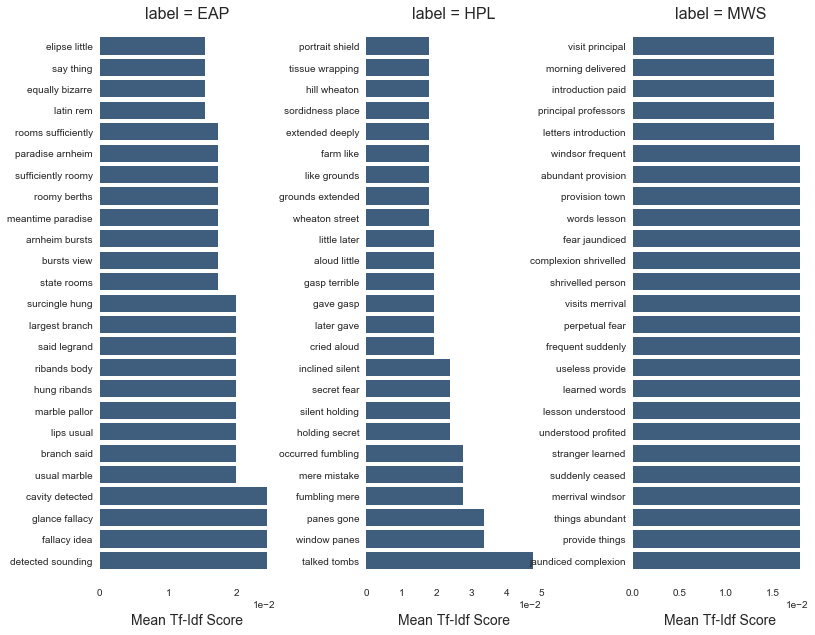

In [35]:
plot_tfidf_classfeats_h(alpha_word)

<h3>Building of bag of word and feature vectors</h3>

In [36]:
#counting_a(1,'word', process = None, lowercase = True, token_pattern = None)[2]

In [37]:
def build_bag_a(a,  analyzer_type, process = None, lowercase = True, token_pattern = None):
    build = counting_a(a, 
                     'word', 
                     process = process, 
                     lowercase = lowercase, 
                     token_pattern = token_pattern)
    
    alpha = top_feats_by_class(build[0], tr1.author, build[1])

    a = list(alpha[0].feature.values)
    b = list(alpha[1].feature.values)
    c = list(alpha[2].feature.values)
    bag = set(a + b + c)
    df_bag = tr1.copy()
    df_bag_test = ts1.copy()

    for w in bag:
        vec = build[0][:, build[1].index(w)].toarray()
        df_bag[w] = vec

        vec_test = build[2][:, build[1].index(w)].toarray()
        df_bag_test[w] = vec_test
        
        
    return df_bag, df_bag_test

In [38]:
print(set(list(build_bag_a(2, 'word')[1]))-set(list(build_bag_a(2, 'word')[0])))


set()


So, we get the top N-gramms of words. Our problem is the depedency on the topic. We need to produce other features which are less dependant on the topic. There are sereveral possibility. Let's detail: <br>
- Stemming<br>
- Character Counting<br>
- Pos_tagging

<h2>Counting of Stem (TBD) (a.k.a bag of character)</h2>


<h2>Counting of Character (a.k.a bag of character)</h2>

Here, we count the use of some caracter, and n-grams of caracter.

<h3>Generation of the tf_idf counting dataFrame</h3>

In [39]:
mat_char, name_char, mat_char_test = counting_a(3, 'word')

print ('Shape of Sparse Matrix: ', mat_char.shape)
print ('Amount of Non-Zero occurences: ', mat_char.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_char.nnz /
                             (mat_char.shape[0] * mat_char.shape[1])))
print(' ')
print ('Shape of Sparse Matrix Test: ', mat_char_test.shape)
print ('Amount of Non-Zero occurences: ', mat_char_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_char_test.nnz /
                             (mat_char_test.shape[0] * mat_char_test.shape[1])))

Shape of Sparse Matrix:  (75, 776)
Amount of Non-Zero occurences:  776
sparsity: 1.33%
 
Shape of Sparse Matrix Test:  (25, 776)
Amount of Non-Zero occurences:  0
sparsity: 0.00%


<h3>Dimensionnality reduction for bag of characters example for 3 gram</h3>
We reduce by taking the TOP-N per author

In [40]:
alpha_char = top_feats_by_class( mat_char, tr1.author, name_char)

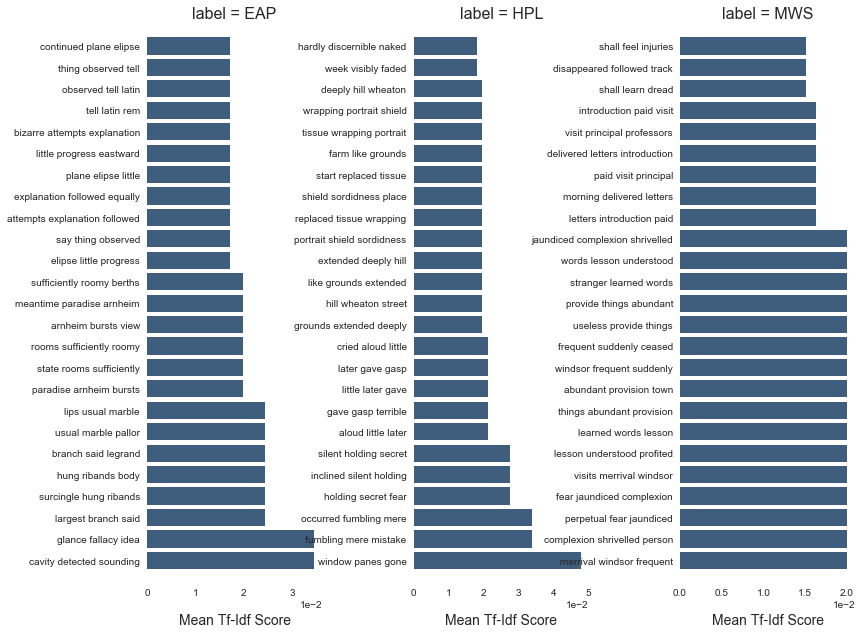

In [41]:
plot_tfidf_classfeats_h(alpha_char)

Blablablablablabla

<h3>Building of bag of character and feature vectors</h3>

In [42]:
build_bag_a(3, 'char')[0].head()


,id,text,author,fear jaundiced complexion,abundant provision town,introduction paid visit,rooms sufficiently roomy,fumbling mere mistake,glance fallacy idea,window panes gone,...,branch said legrand,explanation followed equally,lesson understood profited,merrival windsor frequent,silent holding secret,letters introduction paid,hung ribands body,continued plane elipse,stranger learned words,shield sordidness place
10,id16737,He shall find that I can feel my injuries; he ...,MWS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,id19576,"""The present peculiar condition of affairs at ...",EAP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,id27266,"I say ""thing"" be it observed for they tell me ...",EAP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,id02164,I pointed to the spot where he had disappeared...,MWS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,id24941,"It was useless to provide many things, for we ...",MWS,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2>Counting of POS Tag (a.k.a bag of Tag)</h2>

Here, we count the use of some caracter, and n-grams of caracter.<br>
So we have, some non-topic sensitive features.<br>
But we can produce an other type of feature based on the POS_tagging.

POS tag features. 

We will check the occurence of the elements from the Upenn Tagset. <br>

In [43]:
from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')
#list of all the possible tag names
print("|\\".join(list(tagdict)))

#this is the list of the different tokens we will use.
len(tagdict)

LS|\TO|\VBN|\''|\WP|\UH|\VBG|\JJ|\VBZ|\--|\VBP|\NN|\DT|\PRP|\:|\WP$|\NNPS|\PRP$|\WDT|\(|\)|\.|\,|\``|\$|\RB|\RBR|\RBS|\VBD|\IN|\FW|\RP|\JJR|\JJS|\PDT|\MD|\VB|\WRB|\NNP|\EX|\NNS|\SYM|\CC|\CD|\POS


45

<h3>Function to transform a string to a string of Pos_tag</h3>

In [44]:
def transform_tag(var):
    inpt = nltk.pos_tag(word_tokenize(var))
    unzipped = zip(*inpt )
    return ' '.join([*list(unzipped)[1]])
transform_tag(test)

'DT NN , RB , VBD PRP DT NNS IN VBG DT NNS IN PRP$ NN : IN PRP MD VB PRP$ NN , CC NN TO DT NN NN PRP VBP RP , IN VBG JJ IN DT NN : RB RB JJ VBD DT NN .'

<h3>Generation of the tf_idf counting dataFrame</h3>
We had to adapt the arguments passed in the CountVectorizer.

In [45]:

mat_pos, name_pos, mat_pos_test = counting_a(2, 'word', 
                             process = 'transform_tag',
                             lowercase = False, 
                             token_pattern = 'token_pos')

print ('Shape of Sparse Matrix: ', mat_pos.shape)
print ('Amount of Non-Zero occurences: ', mat_pos.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_pos.nnz /
                             (mat_pos.shape[0] * mat_pos.shape[1])))

print ('Shape of Sparse Test Matrix: ', mat_pos_test.shape)
print ('Amount of Non-Zero occurences: ', mat_pos_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_pos_test.nnz /
                             (mat_pos_test.shape[0] * mat_pos_test.shape[1])))

Shape of Sparse Matrix:  (75, 350)
Amount of Non-Zero occurences:  1866
sparsity: 7.11%
Shape of Sparse Test Matrix:  (25, 350)
Amount of Non-Zero occurences:  692
sparsity: 7.91%


<h3>Dimensionnality reduction for bag of tags Example for 2 grams</h3>
We reduce by taking the TOP-N per author

In [46]:
alpha_pos = top_feats_by_class(mat_pos, tr1.author, name_pos, top_n = 10)

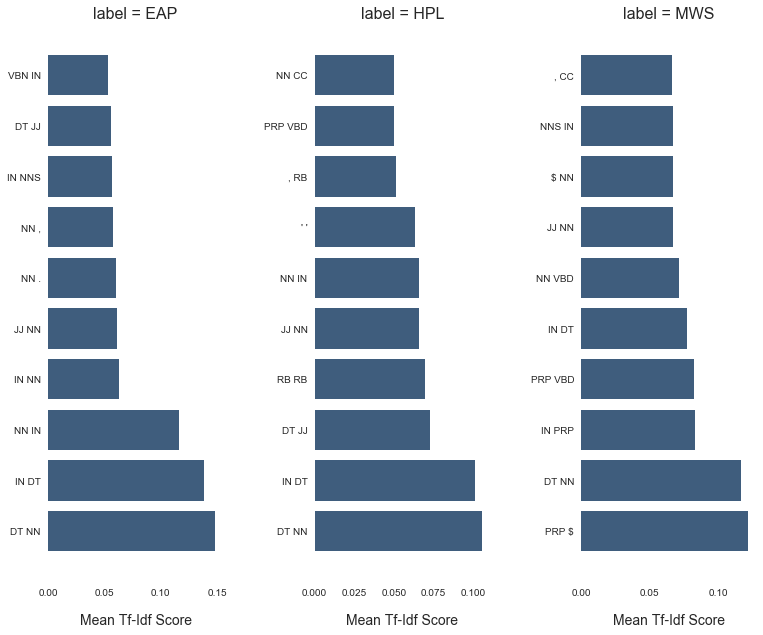

In [47]:
plot_tfidf_classfeats_h(alpha_pos)

<h3>Building of bag of tag and feature vectors</h3>

In [48]:
#build_bag_a(2,'word', 
#          process = 'transform_tag',
#          lowercase = False, 
#          token_pattern = 'token_pos')[0].head()


<h2>Positivness/negativness</h2>

<h4>Weighted sentiment analysis using Vader</h4>
Vader contains a list of 7500 features weighted by how positive or negative they are</h4>
<br>It uses these features to calculate stats on how positive, negative and neutral a passage is<br>
<br>And combines these results to give a compound sentiment (higher = more positive) for the passage<br>
<br>Human trained on twitter data and generally considered good for informal communication<br>
<br>10 humans rated each feature in each tweet in context from -4 to +4</h4>
<br>Calculates the sentiment in a sentence using word order analysis</h4>
<br>"marginally good" will get a lower positive score than "extremely good"
<br>Computes a "compound" score based on heuristics (between -1 and +1)</h4>
<br>Includes sentiment of emoticons, punctuation, and other 'social media' lexicon elements<br>


In [49]:
def vader_comparison(texts):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    headers = ['pos','neg','neu','compound']
    analyzer = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(texts)
    pos=compound=neu=neg=0
    num_sentences = len(sentences)
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos+=vs['pos']/num_sentences
        compound+=vs['compound']/num_sentences
        neu+=vs['neu']/num_sentences
        neg+=vs['neg']/num_sentences
    return pos, neg, neu, compound

def density_positive(var):
    return vader_comparison(var)[0]

def density_negative(var):
    return vader_comparison(var)[1]

def density_neutral(var):
    return vader_comparison(var)[2]

def density_compound(var):
    return vader_comparison(var)[3]

In [50]:
def build_sensi(dataframe):
    df_sen = dataframe.copy() #change here to make sense

    df_sen[density_positive.__name__] = df_sen.text.apply(density_positive)
    df_sen[density_negative.__name__] = df_sen.text.apply(density_negative)
    df_sen[density_neutral.__name__] = df_sen.text.apply(density_neutral)
    df_sen[density_compound.__name__] = df_sen.text.apply(density_compound)
    return df_sen

#build_sensi(tr1).head()

We have all the differents features to add but I'd like to focus on the predections...

<h2>Fusion of the bunch of features.</h2>

In [51]:
#we build here the 2 feature datasets (one for TR1, one for TS1)
#should be adapted when we'll add features

def build_bunch_tr1(dataframe):
    list_df = [build_sensi(dataframe),
               build_meta(dataframe),
               build_bag_a(1,'word')[0],
               build_bag_a(2,'word')[0],
               build_bag_a(3,'word')[0],
               build_bag_a(1,'char')[0],
               build_bag_a(2,'char')[0],
               build_bag_a(3,'char')[0],
               build_bag_a(1,
                         'word', 
                         process = 'transform_tag',
                         lowercase = False, 
                         token_pattern = 'token_pos')[0],
               build_bag_a(2,
                         'word', 
                         process = 'transform_tag',
                         lowercase = False, 
                         token_pattern = 'token_pos')[0],
               build_bag_a(3,
                         'word', 
                         process = 'transform_tag',
                         lowercase = False, 
                         token_pattern = 'token_pos')[0]
              ]

    bunch = pd.merge(list_df[0], list_df[1])
    
    for i in range(2, len(list_df)):
        bunch = pd.merge(bunch, list_df[i])
    
    return bunch

def build_bunch_ts1(dataframe):
    list_df = [build_sensi(dataframe),
               build_meta(dataframe),
               build_bag_a(1,'word')[1], 
               build_bag_a(2,'word')[1], 
               build_bag_a(3,'word')[1], 
               build_bag_a(1,'char')[1],
               build_bag_a(2,'char')[1],
               build_bag_a(3,'char')[1], 
               build_bag_a(1,'word', 
                     process = 'transform_tag',
                     lowercase = False, 
                     token_pattern = 'token_pos')[1],
               build_bag_a(2,'word', 
                     process = 'transform_tag',
                     lowercase = False, 
                     token_pattern = 'token_pos')[1],
               build_bag_a(3,'word', 
                     process = 'transform_tag',
                     lowercase = False, 
                     token_pattern = 'token_pos')[1]
              ]

    bunch = pd.merge(list_df[0], list_df[1])
    
    for i in range(2, len(list_df)):
        bunch = pd.merge(bunch, list_df[i])
    
    return bunch



#df_feat_tr1 = build_bunch_tr1(tr1)
#df_feat_ts1 = build_bunch_ts1(ts1)

In [52]:
"""
print ('Shape of df_feat_tr1 Matrix: ', df_feat_tr1.shape)
print ('Amount of Non-Zero occurences: ', np.count_nonzero(df_feat_tr1.values))
print ('sparsity: %.2f%%' % (100.0 * np.count_nonzero(df_feat_tr1.values) /
                                 (df_feat_tr1.shape[0] * df_feat_tr1.shape[1])))
print('')

print ('Shape of df_feat_ts1 Matrix: ', df_feat_ts1.shape)
print ('Amount of Non-Zero occurences: ', np.count_nonzero(df_feat_ts1.values))
print ('sparsity: %.2f%%' % (100.0 * np.count_nonzero(df_feat_ts1.values) /
                                 (df_feat_ts1.shape[0] * df_feat_ts1.shape[1])))
                                 
"""

"\nprint ('Shape of df_feat_tr1 Matrix: ', df_feat_tr1.shape)\nprint ('Amount of Non-Zero occurences: ', np.count_nonzero(df_feat_tr1.values))\nprint ('sparsity: %.2f%%' % (100.0 * np.count_nonzero(df_feat_tr1.values) /\n                                 (df_feat_tr1.shape[0] * df_feat_tr1.shape[1])))\nprint('')\n\nprint ('Shape of df_feat_ts1 Matrix: ', df_feat_ts1.shape)\nprint ('Amount of Non-Zero occurences: ', np.count_nonzero(df_feat_ts1.values))\nprint ('sparsity: %.2f%%' % (100.0 * np.count_nonzero(df_feat_ts1.values) /\n                                 (df_feat_ts1.shape[0] * df_feat_ts1.shape[1])))\n                                 \n"

<h2>Quantitative parameters transformation</h2>
Quantitative parameters were transferred into a numerical vector with min-max normalization
from 0 to 1. <br>
<br>
It is necessary to have normalized vectors before training our dataset to avoid a disequilibrium among the coefficients.

http://blog.josephmisiti.com/help-commands-for-doing-machine-learning-in-python

In [53]:
def build_normalization(df):
    result = df.copy()
    for feature_name in list(df)[3:]:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value != min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
#build_normalization(df_feat_ts1).head()

So now, we have the normalized features matrix. 

<h1>Prediction: Selection of best set of feature selection technic and prediction model </h1>

<h2>Load and prepare data</h2>

In [54]:
# load dataset

names = author_list
dataframe_train = build_normalization(build_bunch_tr1(tr1))
array = dataframe_train.values
X_train = array[:,3:]
Y_train = array[:,2]


names = author_list
dataframe_test = build_normalization(build_bunch_ts1(ts1))
array = dataframe_test.values
X_test = array[:,3:]
Y_test = array[:,2]

In [55]:
print(np.shape(X_train))
print(np.shape(X_test))

(75, 386)
(25, 386)


<h2>Imports</h2>

In [56]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from pandas import read_csv
from sklearn.decomposition import PCA

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline


import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier)


from sklearn import metrics

from sklearn import model_selection
from sklearn.metrics import log_loss

from sklearn.metrics import fbeta_score, make_scorer

<h2>Feature Selection</h2><br>
See:http://scikit-learn.org/stable/modules/feature_selection.html <br><br>
Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.<br>
<br>
Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.<br>
<br>
Three benefits of performing feature selection before modeling your data are:<br>
<br>
- <b>Reduces Overfitting:</b> Less redundant data means less opportunity to make decisions based on noise.<br>
    <br>
- <b>Improves Accuracy:</b> Less misleading data means modeling accuracy improves.<br>
    <br>
- <b>Reduces Training Time:</b> Less data means that algorithms train faster.
<br><br>I will not follow the paper here but rather I'll follow the following website: <br>

https://machinelearningmastery.com/feature-selection-machine-learning-python/ <br>
see also: https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

So, here we will try a bunch of different methods:<br>
- Univariate feature selection
- Recursive feature elimination
- L1-based feature selection
- Tree-based feature selection


<h3>Number of selected features</h3>

<h4>Current number of features</h4>

In [57]:
print('We have ' + str(np.shape(X_train)[1]) + ' features in total.')

We have 386 features in total.


<h4>Reduction of  number of feaures</h4>
The common possibilities are 10,20, quarter and half of total number of samples. <br>
<br>
For now, we only explore with quarter, tbd for the others.

In [58]:
list_N = [10, 20, int(np.shape(X_train)[1]/4), int(np.shape(X_train)[1]/2)]

print('We want to test our models with ' + str(list_N) + ' features extracted from the ' + str(np.shape(X_train)[1]) + ' previous features')

We want to test our models with [10, 20, 96, 193] features extracted from the 386 previous features


<h3>Univariate feature selection</h3>

In [59]:
def sel_univ(N):
    return SelectKBest(chi2, k=N)

<h3>Recursive feature elimination</h3>

In [60]:
def sel_rec(N):
    model_rec = LogisticRegression()
    return RFE(model_rec, N)

<h3>Principal Component Analysis</h3>


In [61]:
def sel_pca(N):
    return PCA(n_components=N)

<h3>Summary</h3>

In [62]:
selectioners = []
for N in list_N:
    selectioners.append(('S_UNIV_{}'.format(N), sel_univ(N)))
    selectioners.append(('S_REC_{}'.format(N), sel_rec(N)))
    selectioners.append(('S_PCA_{}'.format(N), sel_pca(N)))

<h2>Predictive Models</h2><br>
So here we will try this bunch of feature models:

- LogisticRegression
- LinearDiscriminantAnalysis
- KNeighborsClassifier
- DecisionTreeClassifier
- GaussianNB
- SVC
- GradientBoostingClassifier
- AdaBoostClassifier
- ExtraTreesClassifier
- RandomForestClassifier


In [63]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('ETC', ExtraTreesClassifier()))
models.append(('RFC', RandomForestClassifier()))


<h2>Pipeline</h2><br>

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves two purposes here:<br>
- Convenience and Encapsulation<br>
        You only have to call fit and predict once on your data to fit a whole sequence of estimators.
- Joint parameter selection<br>
        You can grid search over parameters of all estimators in the pipeline at once.
- Safety<br>
        Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

In [64]:
pipes = []

for sel in selectioners:
    for mod in models:
        pipes.append([sel, mod])

<h2>Compare set of selection and predictive models</h2>
<br>


Here, we do ten times :<br>
- First we train over 9/10 of the training set (TR1)
- We test over the 1/10 remaining of the training set (TR1)<br>
<br>
But here we have a problem. Actually, the metric we need to mesure the models is 'neg_log_loss', because it is the one used by Kaggle. But it doesn't work and we don't know why. So, the metric used is accuracy. <br>
<br>
Then, we will take the 10 best models:<br>
- We train over the whole train set(TR1)
- We test over the whole test set (TS1)
- we mesure the best with the neg_log_loss metric (here it's working)<br>
Here the goal is to select the best with the Kaggle metric, but also we want to check if there is or not overfitting. 

Selector: S_UNIV_10 Predictive model: LR: Mean=0.333929 Stand Dev=(0.141523)
Selector: S_UNIV_10 Predictive model: LDA: Mean=0.360714 Stand Dev=(0.083299)
Selector: S_UNIV_10 Predictive model: KNN: Mean=0.376786 Stand Dev=(0.182711)
Selector: S_UNIV_10 Predictive model: CART: Mean=0.375000 Stand Dev=(0.113502)
Selector: S_UNIV_10 Predictive model: NB: Mean=0.389286 Stand Dev=(0.156247)
Selector: S_UNIV_10 Predictive model: SVM: Mean=0.375000 Stand Dev=(0.137396)
Selector: S_UNIV_10 Predictive model: GBC: Mean=0.387500 Stand Dev=(0.105659)
Selector: S_UNIV_10 Predictive model: ABC: Mean=0.387500 Stand Dev=(0.105659)
Selector: S_UNIV_10 Predictive model: ETC: Mean=0.387500 Stand Dev=(0.089660)
Selector: S_UNIV_10 Predictive model: RFC: Mean=0.385714 Stand Dev=(0.083834)
Selector: S_REC_10 Predictive model: LR: Mean=0.512500 Stand Dev=(0.245761)
Selector: S_REC_10 Predictive model: LDA: Mean=0.551786 Stand Dev=(0.245034)
Selector: S_REC_10 Predictive model: KNN: Mean=0.432143 Stand Dev=(0

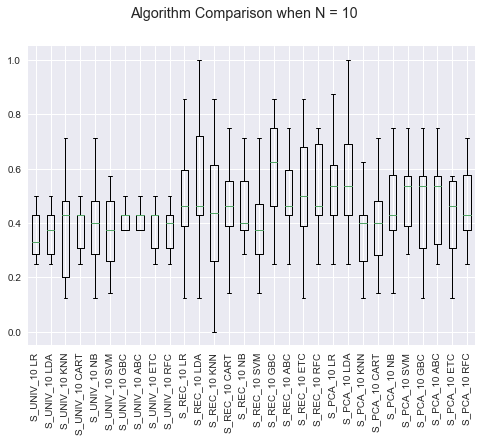

Selector: S_UNIV_20 Predictive model: LR: Mean=0.403571 Stand Dev=(0.165446)
Selector: S_UNIV_20 Predictive model: LDA: Mean=0.346429 Stand Dev=(0.138136)
Selector: S_UNIV_20 Predictive model: KNN: Mean=0.373214 Stand Dev=(0.129867)
Selector: S_UNIV_20 Predictive model: CART: Mean=0.421429 Stand Dev=(0.199681)


/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Selector: S_UNIV_20 Predictive model: NB: Mean=0.375000 Stand Dev=(0.151523)
Selector: S_UNIV_20 Predictive model: SVM: Mean=0.319643 Stand Dev=(0.167410)
Selector: S_UNIV_20 Predictive model: GBC: Mean=0.417857 Stand Dev=(0.136511)
Selector: S_UNIV_20 Predictive model: ABC: Mean=0.403571 Stand Dev=(0.142006)
Selector: S_UNIV_20 Predictive model: ETC: Mean=0.471429 Stand Dev=(0.127075)
Selector: S_UNIV_20 Predictive model: RFC: Mean=0.373214 Stand Dev=(0.173398)
Selector: S_REC_20 Predictive model: LR: Mean=0.483929 Stand Dev=(0.184102)
Selector: S_REC_20 Predictive model: LDA: Mean=0.398214 Stand Dev=(0.147048)
Selector: S_REC_20 Predictive model: KNN: Mean=0.416071 Stand Dev=(0.102597)
Selector: S_REC_20 Predictive model: CART: Mean=0.496429 Stand Dev=(0.253521)
Selector: S_REC_20 Predictive model: NB: Mean=0.373214 Stand Dev=(0.180251)
Selector: S_REC_20 Predictive model: SVM: Mean=0.391071 Stand Dev=(0.155562)
Selector: S_REC_20 Predictive model: GBC: Mean=0.555357 Stand Dev=(0.186

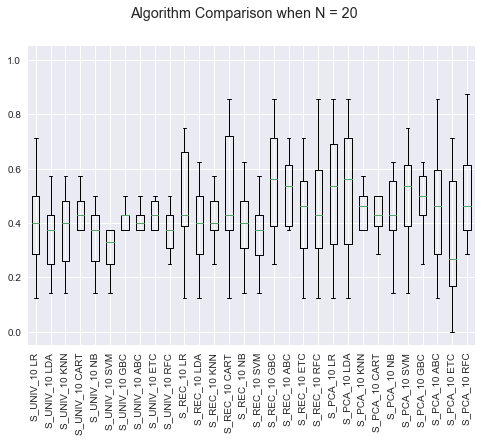

Selector: S_UNIV_96 Predictive model: LR: Mean=0.471429 Stand Dev=(0.178250)
Selector: S_UNIV_96 Predictive model: LDA: Mean=0.323214 Stand Dev=(0.146265)
Selector: S_UNIV_96 Predictive model: KNN: Mean=0.373214 Stand Dev=(0.129867)


/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Selector: S_UNIV_96 Predictive model: CART: Mean=0.430357 Stand Dev=(0.206163)
Selector: S_UNIV_96 Predictive model: NB: Mean=0.430357 Stand Dev=(0.182012)
Selector: S_UNIV_96 Predictive model: SVM: Mean=0.319643 Stand Dev=(0.167410)
Selector: S_UNIV_96 Predictive model: GBC: Mean=0.523214 Stand Dev=(0.211296)
Selector: S_UNIV_96 Predictive model: ABC: Mean=0.455357 Stand Dev=(0.192865)
Selector: S_UNIV_96 Predictive model: ETC: Mean=0.389286 Stand Dev=(0.168804)
Selector: S_UNIV_96 Predictive model: RFC: Mean=0.398214 Stand Dev=(0.189832)
Selector: S_REC_96 Predictive model: LR: Mean=0.483929 Stand Dev=(0.169116)


/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Selector: S_REC_96 Predictive model: LDA: Mean=0.457143 Stand Dev=(0.209652)
Selector: S_REC_96 Predictive model: KNN: Mean=0.467857 Stand Dev=(0.122370)
Selector: S_REC_96 Predictive model: CART: Mean=0.401786 Stand Dev=(0.239079)
Selector: S_REC_96 Predictive model: NB: Mean=0.455357 Stand Dev=(0.195330)
Selector: S_REC_96 Predictive model: SVM: Mean=0.319643 Stand Dev=(0.167410)
Selector: S_REC_96 Predictive model: GBC: Mean=0.571429 Stand Dev=(0.138090)
Selector: S_REC_96 Predictive model: ABC: Mean=0.476786 Stand Dev=(0.193493)
Selector: S_REC_96 Predictive model: ETC: Mean=0.442857 Stand Dev=(0.218091)
Selector: S_REC_96 Predictive model: RFC: Mean=0.348214 Stand Dev=(0.209203)
Selector: S_PCA_96 Predictive model: LR: Mean=0.564286 Stand Dev=(0.193188)
Selector: S_PCA_96 Predictive model: LDA: Mean=0.337500 Stand Dev=(0.118303)


/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Selector: S_PCA_96 Predictive model: KNN: Mean=0.362500 Stand Dev=(0.193822)
Selector: S_PCA_96 Predictive model: CART: Mean=0.453571 Stand Dev=(0.168123)
Selector: S_PCA_96 Predictive model: NB: Mean=0.323214 Stand Dev=(0.183408)
Selector: S_PCA_96 Predictive model: SVM: Mean=0.360714 Stand Dev=(0.152530)
Selector: S_PCA_96 Predictive model: GBC: Mean=0.464286 Stand Dev=(0.189992)
Selector: S_PCA_96 Predictive model: ABC: Mean=0.362500 Stand Dev=(0.135538)
Selector: S_PCA_96 Predictive model: ETC: Mean=0.453571 Stand Dev=(0.167362)
Selector: S_PCA_96 Predictive model: RFC: Mean=0.439286 Stand Dev=(0.183538)


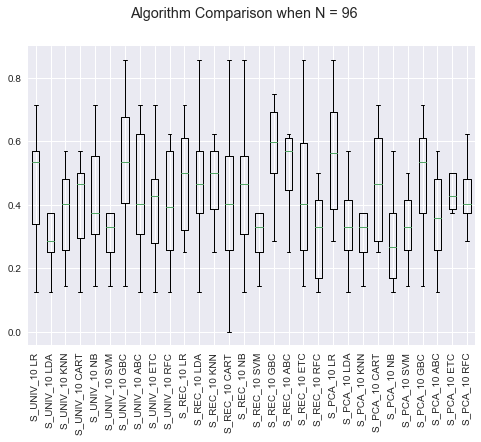

Selector: S_UNIV_193 Predictive model: LR: Mean=0.521429 Stand Dev=(0.163819)
Selector: S_UNIV_193 Predictive model: LDA: Mean=0.501786 Stand Dev=(0.175410)
Selector: S_UNIV_193 Predictive model: KNN: Mean=0.441071 Stand Dev=(0.196437)
Selector: S_UNIV_193 Predictive model: CART: Mean=0.539286 Stand Dev=(0.197368)

/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl


Selector: S_UNIV_193 Predictive model: NB: Mean=0.542857 Stand Dev=(0.180737)
Selector: S_UNIV_193 Predictive model: SVM: Mean=0.319643 Stand Dev=(0.167410)
Selector: S_UNIV_193 Predictive model: GBC: Mean=0.564286 Stand Dev=(0.148160)
Selector: S_UNIV_193 Predictive model: ABC: Mean=0.498214 Stand Dev=(0.150350)
Selector: S_UNIV_193 Predictive model: ETC: Mean=0.469643 Stand Dev=(0.143980)
Selector: S_UNIV_193 Predictive model: RFC: Mean=0.442857 Stand Dev=(0.112882)
Selector: S_REC_193 Predictive model: LR: Mean=0.550000 Stand Dev=(0.175473)


/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Selector: S_REC_193 Predictive model: LDA: Mean=0.494643 Stand Dev=(0.123988)
Selector: S_REC_193 Predictive model: KNN: Mean=0.401786 Stand Dev=(0.174644)
Selector: S_REC_193 Predictive model: CART: Mean=0.405357 Stand Dev=(0.201406)
Selector: S_REC_193 Predictive model: NB: Mean=0.532143 Stand Dev=(0.204041)
Selector: S_REC_193 Predictive model: SVM: Mean=0.319643 Stand Dev=(0.167410)
Selector: S_REC_193 Predictive model: GBC: Mean=0.614286 Stand Dev=(0.142231)
Selector: S_REC_193 Predictive model: ABC: Mean=0.453571 Stand Dev=(0.087190)
Selector: S_REC_193 Predictive model: ETC: Mean=0.446429 Stand Dev=(0.193978)
Selector: S_REC_193 Predictive model: RFC: Mean=0.387500 Stand Dev=(0.189496)
Selector: S_PCA_193 Predictive model: LR: Mean=0.564286 Stand Dev=(0.193188)
Selector: S_PCA_193 Predictive model: LDA: Mean=0.337500 Stand Dev=(0.118303)


/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Selector: S_PCA_193 Predictive model: KNN: Mean=0.362500 Stand Dev=(0.193822)
Selector: S_PCA_193 Predictive model: CART: Mean=0.373214 Stand Dev=(0.185482)
Selector: S_PCA_193 Predictive model: NB: Mean=0.323214 Stand Dev=(0.183408)
Selector: S_PCA_193 Predictive model: SVM: Mean=0.360714 Stand Dev=(0.152530)
Selector: S_PCA_193 Predictive model: GBC: Mean=0.462500 Stand Dev=(0.243205)
Selector: S_PCA_193 Predictive model: ABC: Mean=0.362500 Stand Dev=(0.135538)
Selector: S_PCA_193 Predictive model: ETC: Mean=0.335714 Stand Dev=(0.194438)
Selector: S_PCA_193 Predictive model: RFC: Mean=0.471429 Stand Dev=(0.168502)


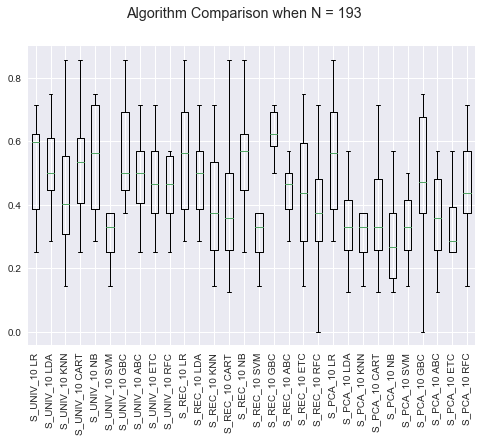

In [65]:
  
# evaluate each model in turn
results = []
names_model = []

results_plot = []
seed = 7
count = 0
count_plot = 0


for feat, model in pipes:
    count +=1
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    pipeline = Pipeline([feat, model])
    #scorer = make_scorer((metrics.log_loss), labels = [0, 1 , 2])
    scorer = 'accuracy'
    cv_results = model_selection.cross_val_score(pipeline,
                                                 X_train,
                                                 Y_train,
                                                 cv=kfold,
                                                 scoring = scorer )
    results.append(cv_results)
    results_plot.append(cv_results)
    names_model.append(feat[0] + ' ' + model[0])
    msg = "%s: Mean=%f Stand Dev=(%f)" % ('Selector: ' + feat[0] + ' Predictive model: ' + model[0], cv_results.mean(), cv_results.std())
    print(msg)
    
    if count%(len(pipes)/(len(list_N)))==0:
        # boxplot algorithm comparison
        fig = plt.figure()
        fig.suptitle('Algorithm Comparison when N = {}'.format(list_N[count_plot]))
        ax = fig.add_subplot(111)
        plt.boxplot(results_plot)
        ax.set_xticklabels(names_model, rotation='vertical')
        plt.show()
        results_plot = []
        count_plot +=1
                

<h2>Selection of selection and predictive models</h2>
<br> We take the three best estimators in mean. These will be tested other the 'TS1' test dataset. <br>
Really not sure about me for the criterion. Because, the variance is important too. We should think about it. 

In [66]:
list_results = []
for i in range(len(results)):
    list_results.append((names_model[i], results[i].mean()))
list_results.sort(key=lambda tup: tup[1], reverse = True)
list_results

[('S_REC_193 GBC', 0.61428571428571421),
 ('S_REC_10 GBC', 0.59999999999999987),
 ('S_PCA_10 LDA', 0.57678571428571435),
 ('S_REC_96 GBC', 0.5714285714285714),
 ('S_PCA_96 LR', 0.56428571428571428),
 ('S_UNIV_193 GBC', 0.56428571428571428),
 ('S_PCA_193 LR', 0.56428571428571428),
 ('S_REC_20 GBC', 0.55535714285714277),
 ('S_REC_10 LDA', 0.55178571428571432),
 ('S_REC_193 LR', 0.54999999999999993),
 ('S_PCA_10 LR', 0.54821428571428565),
 ('S_UNIV_193 NB', 0.54285714285714293),
 ('S_UNIV_193 CART', 0.53928571428571426),
 ('S_PCA_20 RFC', 0.53214285714285714),
 ('S_REC_193 NB', 0.53214285714285714),
 ('S_REC_20 ABC', 0.52500000000000002),
 ('S_PCA_20 LDA', 0.52499999999999991),
 ('S_UNIV_96 GBC', 0.52321428571428563),
 ('S_UNIV_193 LR', 0.52142857142857146),
 ('S_REC_10 ETC', 0.51607142857142851),
 ('S_REC_10 RFC', 0.51607142857142851),
 ('S_REC_10 LR', 0.51249999999999996),
 ('S_PCA_20 LR', 0.51071428571428568),
 ('S_PCA_20 GBC', 0.51071428571428568),
 ('S_REC_10 ABC', 0.5053571428571428

In [67]:
selected_feat_model = list(zip(*list_results[0:10]))[0]
selected_feat_model

('S_REC_193 GBC',
 'S_REC_10 GBC',
 'S_PCA_10 LDA',
 'S_REC_96 GBC',
 'S_PCA_96 LR',
 'S_UNIV_193 GBC',
 'S_PCA_193 LR',
 'S_REC_20 GBC',
 'S_REC_10 LDA',
 'S_REC_193 LR')

<h1>Testing over the Testing dataset</h1> <br>
Now, we have to test the top-10 models over the remaining training set. Our aim is to see how are they are behaviouring over an un-known dataset and select the best. We will also, and it's the most import ensure there is no overfitting. 

<h2>List of selected</h2>

In [68]:
best_pipes = []

for j in range(len(selected_feat_model)):
    for i in range(len(pipes)):
        f = pipes[i][0][0] + ' ' + pipes[i][1][0]
        if f == selected_feat_model[j]:
            best_pipes.append((f, pipes[i]))
#print(best_pipes)            

<h2>Confusion Matrix</h2>

In [69]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve


# import some data to play with

class_names = author_list




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [70]:

def final_plot_confusion(Y_test, Y_pred):

    cm = confusion_matrix(Y_test, Y_pred)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

<h2>Test over Top Pipeline</h2>

In [71]:
log_loss_list = []
for i in range(len(best_pipes)):
    name = best_pipes[i][0]
    pipeline = Pipeline([best_pipes[i][1][0], best_pipes[i][1][1]])
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    y_prob_output = pipeline.predict_proba(X_test) #this is what we send to kaggle.
    result = log_loss(Y_test, y_prob_output)
    log_loss_list.append((name, result, pipeline))

    
log_loss_list.sort(key=lambda tup: tup[1], reverse = False)
#log_loss_list

In [72]:
winner = log_loss_list[0]
print('The best combination Number, Processing, Model is ' 
      + winner[0]
     + ' with a log_loss score of '
     + str(winner[1]))

The best combination Number, Processing, Model is S_PCA_10 LDA with a log_loss score of 1.33171964493


<h2>Confusion Matrix</h2>

Confusion matrix, without normalization
[[3 2 6]
 [5 1 2]
 [2 0 4]]
Normalized confusion matrix
[[ 0.27272727  0.18181818  0.54545455]
 [ 0.625       0.125       0.25      ]
 [ 0.33333333  0.          0.66666667]]


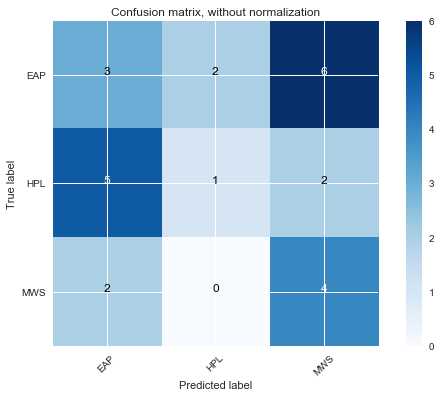

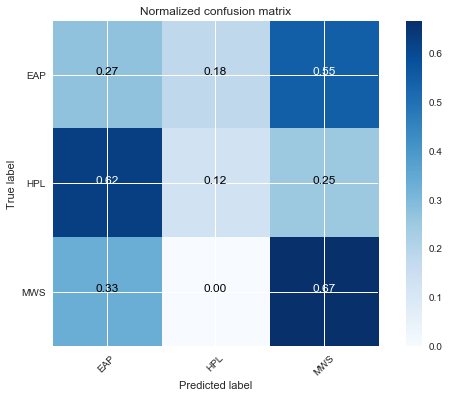

In [73]:
pipeline = winner[2]
pipeline.fit(X_train, Y_train)
Y_pred = pipeline.predict(X_test)
y_prob_output = pipeline.predict_proba(X_test)  
final_plot_confusion(Y_test, Y_pred)  

<h2>Submission to Kaggle</h2>
First, we must adapt the features building functions.

<h3>Loading Test Set</h3>

In [74]:
#loading of test dataset
test = pd.read_csv("test.csv")

test.text= test.text.astype(str)

test = test[0:30] #for coding 
#construction of the feature vectors


<h3>Adapting building functions</h3>

In [75]:

def counting_a_test(a, analyzer_type, process = None, lowercase = True, token_pattern = None):
    
    
    if token_pattern == None:
        bow_transformer = CountVectorizer(analyzer = analyzer_type,
                                      lowercase = lowercase,
                                      ngram_range = (a, a),
                                      stop_words='english')
    elif token_pattern == 'token_pos':
        bow_transformer = CountVectorizer(analyzer = analyzer_type,
                                          lowercase = lowercase,
                                          ngram_range = (a, a),
                                          token_pattern =  r"(?u)\b\w\w+\b|!|\?|\"|\'|\.|\,|\;|\:|\$|\(|\)|\--|\&|\``|\'' + PRP$ + WP$",
                                          stop_words='english')

    if process == None: 
        bow_transformer.fit(train['text'])
        messages_bow = bow_transformer.transform(train['text'])
        messages_bow_test = bow_transformer.transform(test['text'])  
    elif process == 'transform_tag':
        bow_transformer.fit(train['text'].apply(transform_tag))
        messages_bow = bow_transformer.transform(train['text'].apply(transform_tag))
        messages_bow_test = bow_transformer.transform(test['text'].apply(transform_tag))
        
    #this is the DataFrame Concerning the regular counting of words
    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    messages_tfidf_test = tfidf_transformer.transform(messages_bow_test)
    
    names = bow_transformer.get_feature_names()
    
    return messages_tfidf, names, messages_tfidf_test
   


In [76]:
#should be adapted when we'll add features

def build_bag_a_test(a,  analyzer_type, process = None, lowercase = True, token_pattern = None):
    build = counting_a_test(a, 
                     'word', 
                     process = process, 
                     lowercase = lowercase, 
                     token_pattern = token_pattern)
    
    alpha = top_feats_by_class(build[0], tr1.author, build[1])

    a = list(alpha[0].feature.values)
    b = list(alpha[1].feature.values)
    c = list(alpha[2].feature.values)
    bag = set(a + b + c)
    df_bag = train.copy()
    df_bag_test = test.copy()

    for w in bag:
        vec = build[0][:, build[1].index(w)].toarray()
        df_bag[w] = vec

        vec_test = build[2][:, build[1].index(w)].toarray()
        df_bag_test[w] = vec_test
        
        
    return df_bag, df_bag_test

In [77]:
#we build here the 2 feature datasets (one for TR1, one for TS1)
def build_bunch_train(dataframe):
    list_df = [build_sensi(dataframe),
               build_meta(dataframe),
               build_bag_a_test(1,'word')[0],
               build_bag_a_test(2,'word')[0],
               build_bag_a_test(3,'word')[0],
               build_bag_a_test(1,'char')[0],
               build_bag_a_test(2,'char')[0],
               build_bag_a_test(3,'char')[0],
               build_bag_a_test(1,
                         'word', 
                         process = 'transform_tag',
                         lowercase = False, 
                         token_pattern = 'token_pos')[0],
               build_bag_a_test(2,
                         'word', 
                         process = 'transform_tag',
                         lowercase = False, 
                         token_pattern = 'token_pos')[0],
               build_bag_a_test(3,
                         'word', 
                         process = 'transform_tag',
                         lowercase = False, 
                         token_pattern = 'token_pos')[0]
              ]

    bunch = pd.merge(list_df[0], list_df[1])
    
    for i in range(2, len(list_df)):
        bunch = pd.merge(bunch, list_df[i])
    
    return bunch

def build_bunch_test(dataframe):
    list_df = [build_sensi(dataframe),
               build_meta(dataframe),
               build_bag_a_test(1,'word')[1], 
               build_bag_a_test(2,'word')[1], 
               build_bag_a_test(3,'word')[1], 
               build_bag_a_test(1,'char')[1],
               build_bag_a_test(2,'char')[1],
               build_bag_a_test(3,'char')[1], 
               build_bag_a_test(1,'word', 
                     process = 'transform_tag',
                     lowercase = False, 
                     token_pattern = 'token_pos')[1],
               build_bag_a_test(2,'word', 
                     process = 'transform_tag',
                     lowercase = False, 
                     token_pattern = 'token_pos')[1],
               build_bag_a_test(3,'word', 
                     process = 'transform_tag',
                     lowercase = False, 
                     token_pattern = 'token_pos')[1]
              ]

    bunch = pd.merge(list_df[0], list_df[1])
    
    for i in range(2, len(list_df)):
        bunch = pd.merge(bunch, list_df[i])
    
    return bunch

#df_feat_train = build_bunch_train(train)
df_feat_test = build_bunch_test(test)

<h3>Training over all the Training Dataset</h3>

In [78]:
# load dataset

names = author_list
dataframe_train = build_normalization(build_bunch_train(train))
array = dataframe_train.values
X_train = array[:,3:]
Y_train = array[:,2]

names = author_list
dataframe_test = build_normalization(build_bunch_test(test))
array = dataframe_test.values
X_test = array[:,2:]
Y_test = array[:,2]

In [79]:
#training
pipeline = winner[2]
pipeline.fit(X_train, Y_train)


Pipeline(memory=None,
     steps=[('S_PCA_10', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))])

<h3>Generating the probabilities</h3>

In [80]:
Y_pred = pipeline.predict(X_test)
y_prob_output = pipeline.predict_proba(X_test)

In [81]:
print(y_prob_output)

[[ 0.19362778  0.12997378  0.67639844]
 [ 0.62645881  0.2063002   0.16724099]
 [ 0.30396078  0.32824069  0.36779853]
 [ 0.318928    0.24442425  0.43664775]
 [ 0.27057207  0.20677006  0.52265787]
 [ 0.4011338   0.29154299  0.3073232 ]
 [ 0.48200641  0.40033834  0.11765524]
 [ 0.16476152  0.24054137  0.5946971 ]
 [ 0.61384306  0.25344081  0.13271613]
 [ 0.46894088  0.44252599  0.08853313]
 [ 0.34190332  0.25716923  0.40092746]
 [ 0.27798312  0.33021552  0.39180136]
 [ 0.22147673  0.1355737   0.64294958]
 [ 0.38215189  0.37177762  0.24607049]
 [ 0.46469062  0.4338128   0.10149658]
 [ 0.42565334  0.24864531  0.32570136]
 [ 0.2812866   0.26901747  0.44969593]
 [ 0.52871207  0.33219385  0.13909408]
 [ 0.40842333  0.32871477  0.2628619 ]
 [ 0.3543366   0.2870998   0.3585636 ]
 [ 0.51598657  0.328315    0.15569843]
 [ 0.29090611  0.19855296  0.51054093]
 [ 0.47895623  0.41213013  0.10891364]
 [ 0.44033103  0.45655     0.10311897]
 [ 0.39668874  0.26357939  0.33973187]
 [ 0.28362641  0.23123132

<h3>CSV File</h3>

In [82]:
y_prob_output[:,0]

array([ 0.19362778,  0.62645881,  0.30396078,  0.318928  ,  0.27057207,
        0.4011338 ,  0.48200641,  0.16476152,  0.61384306,  0.46894088,
        0.34190332,  0.27798312,  0.22147673,  0.38215189,  0.46469062,
        0.42565334,  0.2812866 ,  0.52871207,  0.40842333,  0.3543366 ,
        0.51598657,  0.29090611,  0.47895623,  0.44033103,  0.39668874,
        0.28362641,  0.37921148,  0.57163341,  0.20227902,  0.28543773])

In [83]:
df_submit = pd.DataFrame(columns = ['id',"EAP","HPL","MWS"])
df_submit['id'] = test['id']
df_submit['EAP'] = y_prob_output[:,0]
df_submit['HPL'] = y_prob_output[:,1]
df_submit['MWS'] = y_prob_output[:,2]
df_submit


,id,EAP,HPL,MWS
0,id02310,0.193628,0.129974,0.676398
1,id24541,0.626459,0.206300,0.167241
2,id00134,0.303961,0.328241,0.367799
3,id27757,0.318928,0.244424,0.436648
4,id04081,0.270572,0.206770,0.522658
5,id27337,0.401134,0.291543,0.307323
6,id24265,0.482006,0.400338,0.117655
7,id25917,0.164762,0.240541,0.594697
8,id04951,0.613843,0.253441,0.132716
9,id14549,0.468941,0.442526,0.088533


In [84]:
df_submit.to_csv('submission.csv', index=False)

In [85]:
end_time = datetime.now()

print('Congratulation, project is done ! It took: ' + str(end_time - start_time))

Congratulation, project is done ! It took: 0:04:28.094623
